In [40]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import class_weight
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.applications import ResNet50
from keras.callbacks import TensorBoard

In [41]:
drive_base_path = "../"
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_balanced_images = drive_base_path + "dataset/Balanced_Training_Input_Aug/"
path_to_test = drive_base_path + "/dataset/ISIC2018_VGG16_Training_AUG/"

In [42]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

In [43]:
def load_sample(path_to_images, number_of_images):
    list_of_images = os.listdir(path_to_images)
    x = []
    for i, filename in enumerate(list_of_images):
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x.append(image)
        
        if i >= number_of_images:
            break
    
    x = np.array(x)
    return x       

In [44]:
x = load_sample(path_to_images, 1000)
print(x.shape)

(1001, 450, 600, 3)


In [45]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    zoom_range=0.2,
    brightness_range=(0.8, 1),
    fill_mode='constant',
    cval=0,
    data_format="channels_last")

In [46]:
datagen.fit(x)

In [47]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
train_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=32,
                    classes=classes,
#                     save_to_dir=path_to_test,
#                     save_format='jpeg',
                    shuffle=True)

Found 32756 images belonging to 7 classes.


In [48]:
samples = train_generator.samples

In [49]:
_x, _y = next(train_generator)

In [50]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

print(class_weights)

[1.05108458 0.69790135 1.11071174 1.10078301 1.0644742  1.07895517
 1.0630233 ]


# DEFINING THE MODEL

In [51]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(lr=1e-3), 
              metrics=["acc"])
print(model.summary())

/data/anaconda/envs/py36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
batch_size = 32
epochs = 3
history = model.fit_generator(train_generator, 
                              epochs=epochs,
#                               class_weight=class_weight,
                              steps_per_epoch=samples / batch_size,
                              callbacks=[tensorboard],
                              verbose=1)

Epoch 1/3
 537/1023 [==============>...............] - ETA: 7:32 - loss: 1.1023 - acc: 0.5918

In [46]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

for layer in model.layers[:161]:
    layer.trainable = False
for layer in model.layers[161:]:
    layer.trainable = True

# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1 False
3 bn_conv1 False
4 activation_1 False
5 pool1_pad False
6 max_pooling2d_1 False
7 res2a_branch2a False
8 bn2a_branch2a False
9 activation_2 False
10 res2a_branch2b False
11 bn2a_branch2b False
12 activation_3 False
13 res2a_branch2c False
14 res2a_branch1 False
15 bn2a_branch2c False
16 bn2a_branch1 False
17 add_1 False
18 activation_4 False
19 res2b_branch2a False
20 bn2b_branch2a False
21 activation_5 False
22 res2b_branch2b False
23 bn2b_branch2b False
24 activation_6 False
25 res2b_branch2c False
26 bn2b_branch2c False
27 add_2 False
28 activation_7 False
29 res2c_branch2a False
30 bn2c_branch2a False
31 activation_8 False
32 res2c_branch2b False
33 bn2c_branch2b False
34 activation_9 False
35 res2c_branch2c False
36 bn2c_branch2c False
37 add_3 False
38 activation_10 False
39 res3a_branch2a False
40 bn3a_branch2a False
41 activation_11 False
42 res3a_branch2b False
43 bn3a_branch2b False
44 activation_12 False
45 res3a_branch2c False

In [ ]:
model.compile(optimizer=SGD(lr=1e-3, momentum=0.9), loss='categorical_crossentropy', metrics=["acc"])
epochs = 15
batch_size = 32
history = model.fit_generator(train_generator, 
                              steps_per_epoch=samples / batch_size,
                              epochs=epochs,
#                               class_weight=class_weights,
                              verbose=1)
model.save_weights(drive_base_path + 'models/ResNet50_ISIC.h5')
# model.evaluate(X_test, y_test)

Epoch 1/15
1024/1023 [==============================] - 656s 641ms/step - loss: 0.4215 - acc: 0.8438
Epoch 3/15
1024/1023 [==============================] - 633s 618ms/step - loss: 0.3398 - acc: 0.8747
Epoch 4/15
1024/1023 [==============================] - 622s 608ms/step - loss: 0.2864 - acc: 0.8945
Epoch 5/15
1024/1023 [==============================] - 605s 590ms/step - loss: 0.2459 - acc: 0.9108
Epoch 6/15
1024/1023 [==============================] - 603s 589ms/step - loss: 0.2153 - acc: 0.9227
Epoch 7/15
1024/1023 [==============================] - 605s 591ms/step - loss: 0.1914 - acc: 0.9314
Epoch 8/15
1019/1023 [============================>.] - ETA: 2s - loss: 0.1731 - acc: 0.9376

# ACCURACY AND LOSS PLOTS

dict_keys(['loss', 'acc'])


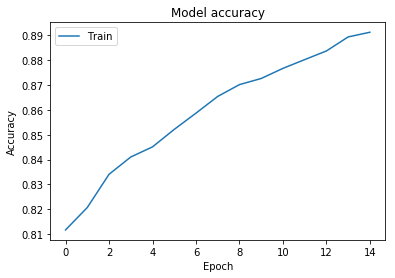

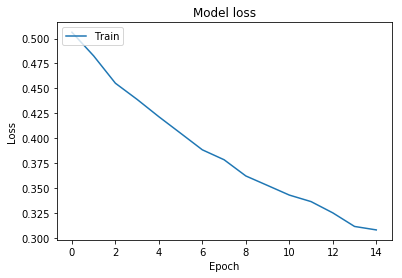

In [14]:
# Plot Training and Validation Accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# ISIC LIVE IMAGE TEST/VALIDATION DATA

In [25]:
# TESTTING ON ISIC LIVE IMAGE DATA
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Test_Input/"

In [26]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    path_to_images = path_to_images + 'test/'
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2]
        
        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        
        image = cv2.resize(image, (new_size[1], new_size[0]))
        
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                     cv2.BORDER_CONSTANT, value=color)
        images_list.append(new_img)

    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [27]:
x_test, names = preprocess_images(path_to_images)

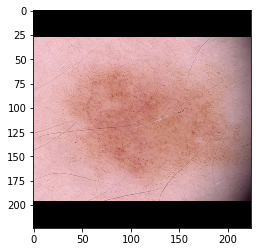

In [28]:
plt.imshow(x_test[0])

In [29]:
print(x_test.shape)
print(names.shape)

(1512, 224, 224, 3)
(1512, 1)


In [30]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    fill_mode='constant',
    data_format="channels_last")

In [31]:
datagen.fit(x_test)

In [32]:
test_generator = datagen.flow(
                    x_test,
                    batch_size=1,
                    shuffle=False)

In [33]:
model.load_weights(drive_base_path + 'models/ResNet50_ISIC.h5')

In [34]:
predictions = model.predict_generator(test_generator, steps=len(x_test))
# classes = (predictions > 0.5).astype(np.float)
# print(classes.shape)

In [35]:
print(predictions.shape)

(1512, 7)


In [36]:
final_output = np.concatenate((names, predictions), axis=1)
final_output.shape

(1512, 8)

In [37]:
import csv

with open(drive_base_path + "output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)